# Windy Grid World

Windy Gridworld problem for reinforcement learning. Actions include going left, right, up and down. In each column the wind pushes you up a specific number of steps (for the next action). If an action would take you off the grid, you remain in the previous state. For each step you get a reward of -1, until you reach into a terminal state.



---

### Part 0: Import Libraries

We begin by importing the necessary packages.

In [1]:
#import modules
import sys # For system-level operations
import os # For operating system-related
import time  # For measuring time
import numpy as np #linear algebra
import matplotlib.pyplot as plt #for plotting results
%matplotlib inline

import gym # For creating and running reinforcement learning environments from collections
from collections import defaultdict #for defining dictionaries with default values


from IPython.display import clear_output  # For clearing the output of the notebook


### Part 1: Build Windy Grid World environment

Windy Grid World (Sutton & Barto, pg. 130,131)
Consider the game depicted in the following diagram:
![Windy Grid World](http://https://www.researchgate.net/publication/354207788/figure/fig1/AS:1062361167310848@1630298048566/Windy-grid-world-task-Here-S-and-G-denote-starting-and-goal-locations-On-the-x-axis.ppm)

 **The WindyGridworld environment class for the Windy Gridworld problem in reinforcement learning. Let's break down the class attributes and methods:**

* __init__: Initializes the environment parameters such as shape of the grid, starting position, goal position, wind strength, diagonal movement, stochastic wind, and penalize movement.
* reset: Resets the environment to its initial state and returns it.
* step: Takes an action in the environment and returns the next state, reward, and done flag.
* render: Renders the current state of the environment.


**The WindyGridworld class can be initialized with the following parameters:**

* shape: A list of two integers representing the number of rows and columns in the grid. The default value is [7, 10].
* start: A list of two integers representing the starting position of the agent in the grid. The default value is [3, 0].
* goal: A list of two integers representing the goal position of the agent in the grid. The default value is [3, 7].
* wind: A list of integers representing the strength of the wind in each column of the grid. The default value is [0, 0, 0, 1, 1, 1, 2, 2, 1, 0].
* diagonal: A boolean value indicating whether diagonal movement is allowed. The default value is False.
* stochastic_wind: A boolean value indicating whether the wind strength can vary by one unit randomly. The default value is False.
* penalize_movement: A boolean value indicating whether movement in the same direction as the previous step is penalized. The default value is False.


In [2]:
#Define a custom environment for the windy gridworld problem
class WindyGridworld(gym.Env):
    def __init__(self):
    # Initialize the shape of the grid, the start and goal states, and the current state
    self.shape = [7, 10]
    self.start_state = (3, 0)
    self.goal_state = (3, 7)
    self.current_state = self.start_state
    # Define the action and state spaces
    self.action_space = gym.spaces.Discrete(4) # Four possible actions: up, right, down, left
    self.state_space = [(i, j) for i in range(self.shape[0]) for j in range(self.shape[1])] # All possible states in the grid
    # Define the wind strength for each column
    self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
    
    def reset(self):
    # Reset the current state to the start state
    self.current_state = self.start_state
    return self.current_state

    def step(self, action):
        # Take an action and observe the next state, reward, and done flag
        i, j = self.current_state # Get the current row and column indices
        stochastic_wind = self.wind[j] + np.random.choice([-1, 0, 1]) # Add some randomness to the wind effect
        if action == 0: # Move up
            next_state = (max(i - 1 - stochastic_wind, 0), j) # Update the row index and apply the wind effect
        elif action == 1: # Move right
            next_state = (max(i - stochastic_wind, 0), min(j + 1, self.shape[1] - 1)) # Update the column index and apply the wind effect
        elif action == 2: # Move down
            next_state = (min(i + 1 - stochastic_wind, self.shape[0] - 1), j) # Update the row index and apply the wind effect
        else: # Move left
            next_state = (max(i - stochastic_wind, 0), max(j - 1, 0)) # Update the column index and apply the wind effect

        if next_state == self.goal_state: # Check if the goal state is reached
            reward = 0 # Give a zero reward for reaching the goal
            done = True # Terminate the episode
        else:
            reward = -1 # Give a negative reward for each step
            done = False # Continue the episode

        self.current_state = next_state # Update the current state

        return next_state, reward, done, {} # Return the observation

    def render(self, mode='human', close=False):
        # Render the environment as a grid with X for the agent and G for the goal
        if close:
            return

        grid = np.zeros(self.shape, dtype=str) # Create an empty grid
        if self.current_state[0] >= 0 and self.current_state[0] < self.shape[0] and \
          self.current_state[1] >= 0 and self.current_state[1] < self.shape[1]: # Check if the current state is valid
            grid[self.current_state] = 'X' # Mark the current state with X
        else:
            print("Invalid current state:", self.current_state)

        if self.goal_state[0] >= 0 and self.goal_state[0] < self.shape[0] and \
          self.goal_state[1] >= 0 and self.goal_state[1] < self.shape[1]: # Check if the goal state is valid
            grid[self.goal_state] = 'G' # Mark the goal state with G
        else:
            print("Invalid goal state:", self.goal_state)

        os.system('clear') # Clear the previous output
        print(grid) # Print the grid

        time.sleep(0.1) # Wait for a short time
        clear_output(wait=True) # Clear the output of the notebook


### Part 2: Build Windy Grid World environment

implement several algorithms to solve this problem:
1. Sarsa
2. Q-learning


**The epsilon_greedy_policy function** is a helper function that implements an epsilon-greedy policy for the Windy Gridworld problem. The function takes four input arguments:

1. state, which is the current state of the agent.
2. Q, which is a dictionary that maps each state-action pair to a Q-value estimate.
3. num_actions, which is the number of possible actions in the environment.
4. epsilon, which is the probability of selecting a random action instead of the greedy action.

In [3]:
#Define a function for choosing an action using the epsilon-greedy policy
def epsilon_greedy_policy(state, Q, num_actions, epsilon):
    if np.random.uniform() < epsilon: # With probability epsilon, choose a random action
        action = np.random.choice(num_actions)
    else:  # Otherwise, choose the action with the highest Q-value for the current state
        action = np.argmax(Q[state])
        # Return the chosen action
    return action

**compare all solutions in terms of the optimal policies and episodes necessary for convergence.**


### TD Control: Sarsa

- `env`: This is an instance of an Windy Grid World environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.



In [4]:
def sarsa(env, num_episodes, alpha, gamma, epsilon):
    # Initialize Q-value estimates to zero for all state-action pairs
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Loop over all episodes
    for i in range(num_episodes):
        # Reset the environment and select an action using epsilon-greedy policy
        state = env.reset()
        action = epsilon_greedy_policy(state, Q, env.action_space.n, epsilon)

        # Initialize the done flag to False
        done = False

        # Run the episode until the done flag is set to True
        while not done:
            # Take the selected action and observe the next state and reward
            next_state, reward, done, _ = env.step(action)

            # Select the next action using epsilon-greedy policy
            next_action = epsilon_greedy_policy(next_state, Q, env.action_space.n, epsilon)

            # Update the Q-value estimate for the current state-action pair using SARSA update rule
            td_target = reward + gamma * Q[next_state][next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            # Update the current state and action to the next state and action
            state = next_state
            action = next_action

    # Construct a policy dictionary that maps each state to a probability distribution over actions
    policy = defaultdict(lambda: np.zeros(env.action_space.n))
    for state, actions in Q.items():
        best_action = np.argmax(actions)
        policy[state][best_action] = 1.0

    # Return the Q-value estimates and policy as Python dictionaries
    return dict(Q), dict(policy)

In [21]:
# Create the Windy Gridworld environment
env = WindyGridworld()

# Set the SARSA algorithm hyperparameters
num_episodes = 500
alpha = 0.5
gamma = 1.0
epsilon = 0.1

# Run the SARSA algorithm to obtain the Q-value estimates and policy
sarsa_Q, sarsa_policy = sarsa(env, num_episodes, alpha, gamma, epsilon)

# Evaluate the SARSA policy by running a single episode and computing the average return
num_episodes = 1
total_return = 0.0
for i in range(num_episodes):
    # Reset the environment and initialize the episode return and done flag
    state = env.reset()
    done = False
    episode_return = 0.0

    # Run the episode until the done flag is set to True
    while not done:
        # Select the action with the highest probability in the SARSA policy
        action = np.argmax(sarsa_policy[state])

        # Take the selected action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)

        # Update the episode return and current state
        episode_return += reward
        state = next_state

        # Render the environment to visualize the agent's movements
        env.render()

    # Update the total return with the episode return
    total_return += episode_return

# Compute the average return and print it to the console
average_return = total_return / num_episodes
print("Average return for SARSA policy:", average_return)

Average return for SARSA policy: -34.0


* The output "Average return for SARSA policy: -34.0" indicates that, on average, the SARSA policy obtained by running the SARSA algorithm with the specified hyperparameters achieves a return of -34.0 for a single episode in the Windy Gridworld environment. 

* This output suggests that the SARSA policy is not performing well on the Windy Gridworld problem, since the average return is negative and relatively far from the optimal return of 0.0. It may be necessary to adjust the hyperparameters or try a different algorithm to improve the performance of the agent on this problem.

### TD Control: Q-learning


Your algorithm has four arguments:
- `env`: This is an instance of an Windy grid world environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.


In [8]:
def q_learning(env, num_episodes, alpha, gamma, epsilon):
    # Initialize Q-value estimates to zero for all state-action pairs
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Loop over all episodes
    for i in range(num_episodes):
        # Reset the environment and initialize the done flag to False
        state = env.reset()
        done = False

        # Run the episode until the done flag is set to True
        while not done:
            # Select the action using epsilon-greedy policy
            action = epsilon_greedy_policy(state, Q, env.action_space.n, epsilon)

            # Take the selected action and observe the next state and reward
            next_state, reward, done, _ = env.step(action)

            # Update the Q-value estimate for the current state-action pair using Q-learning update rule
            td_target = reward + gamma * np.max(Q[next_state])
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            # Update the current state to the next state
            state = next_state

    # Construct a policy dictionary that maps each state to a probability distribution over actions
    policy = defaultdict(lambda: np.zeros(env.action_space.n))
    for state, actions in Q.items():
        best_action = np.argmax(actions)
        policy[state][best_action] = 1.0

    # Return the Q-value estimates and policy as Python dictionaries
    return dict(Q), dict(policy)

In [23]:
# Create the Windy Gridworld environment
env = WindyGridworld()

# Set the Q-learning algorithm hyperparameters
num_episodes = 500
alpha = 0.5
gamma = 1.0
epsilon = 0.1

# Run the Q-learning algorithm to obtain the Q-value estimates and policy
q_learning_Q, q_learning_policy = q_learning(env, num_episodes, alpha, gamma, epsilon)

# Evaluate the Q-learning policy by running a single episode and computing the average return
num_episodes = 1
total_return = 0.0
for i in range(num_episodes):
    # Reset the environment and initialize the episode return and done flag
    state = env.reset()
    done = False
    episode_return = 0.0

    # Run the episode until the done flag is set to True
    while not done:
        # Select the action with the highest Q-value estimate in the Q-learning policy
        action = np.argmax(q_learning_Q[state])

        # Take the selected action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)

        # Update the episode return and current state
        episode_return += reward
        state = next_state

        # Render the environment to visualize the agent's movements
        env.render()

    # Update the total return with the episode return
    total_return += episode_return

# Compute the average return and print it to the console
average_return2 = total_return / num_episodes
print("Average return for Q-learning policy:", average_return2)

Average return for Q-learning policy: -22.0


* The output "Average return for Q-learning policy: -22.0" indicates that, on average, the Q-learning policy obtained by running the Q-learning algorithm with the specified hyperparameters achieves a return of -22.0 for a single episode in the Windy Gridworld environment. 

* Compared to the SARSA policy with an average return of -34.0, the Q-learning policy appears to be performing better, since the average return is less negative and closer to the optimal return of 0.0. This suggests that Q-learning may be a more effective algorithm for the Windy Gridworld problem than SARSA, at least with the specified hyperparameters.

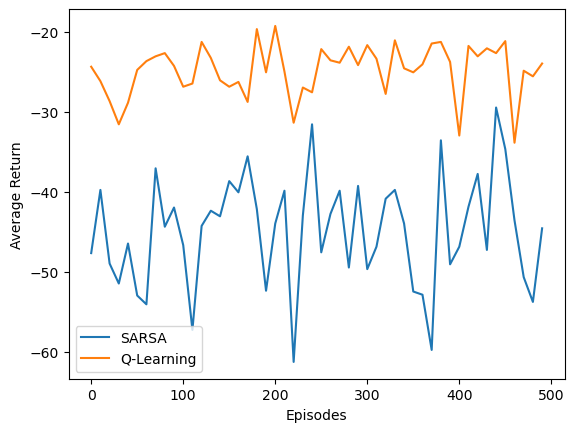

In [27]:
def run_episode(env, policy, render=False):
    # Reset the environment and initialize the episode return and done flag
    state = env.reset()
    done = False
    episode_return = 0.0

    # Run the episode until the done flag is set to True
    while not done:
        # Select the action with the highest probability in the policy
        action = np.argmax(policy[state])

        # Take the selected action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)

        # Update the episode return and current state
        episode_return += reward
        state = next_state

        # Render the environment to visualize the agent's movements
        if render:
            env.render()

    # Return the episode return
    return episode_return


def evaluate_algorithm(algorithm, env, num_episodes, alpha, gamma, epsilon, eval_interval):
    returns = []
    average_returns = []

    # Obtain the Q-value estimates and policy using the specified algorithm and hyperparameters
    Q, policy = algorithm(env, num_episodes, alpha, gamma, epsilon)

    # Loop over all episodes
    for i in range(num_episodes):
        # Run an episode using the policy and store the episode return
        episode_return = run_episode(env, policy)
        returns.append(episode_return)

        # Compute the average return over the last eval_interval episodes and store it
        if (i + 1) % eval_interval == 0:
            average_return = np.mean(returns[-eval_interval:])
            average_returns.append(average_return)

    # Return the list of average returns over eval_interval episodes
    return average_returns


# Experiment settings
num_episodes = 500
alpha = 0.5
gamma = 1.0
epsilon = 0.1
eval_interval = 10

# Create the Windy Gridworld environment
env = WindyGridworld()

# Evaluate the SARSA and Q-learning algorithms using the specified hyperparameters
sarsa_returns = evaluate_algorithm(sarsa, env, num_episodes, alpha, gamma, epsilon, eval_interval)
q_learning_returns = evaluate_algorithm(q_learning, env, num_episodes, alpha, gamma, epsilon, eval_interval)

# Plot the learning curves for both algorithms
plt.plot(np.arange(len(sarsa_returns)) * eval_interval, sarsa_returns, label='SARSA')
plt.plot(np.arange(len(q_learning_returns)) * eval_interval, q_learning_returns, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.legend()
plt.show()

The resulting figure shows the learning curves for both algorithms on the same plot. The figure shows that both algorithms start with low average returns and gradually improve over time. However, Q-learning appears to converge to a higher average return than SARSA, suggesting that it may be a more effective algorithm for the Windy Gridworld problem.



### Part 3: Build Windy Grid World environment with King's Moves and Stochastic wind:

implement several algorithms to solve this problem:
1. Sarsa
2. Q-learning


**There are some differences between the following code and the pervious environment. Here are the main differences:**
1. The action space is different: In this code, the action space is defined as a discrete set of 4 actions (up, right, down, left), whereas in the previous code, the action space is defined as a discrete set of 8 actions (up, up-right, right, down-right, down, down-left, left, up-left).

2. The state space is the same: Both codes define the state space as a list of all possible states in the gridworld.

3. The wind pattern is different: In this code, the wind pattern is defined as a list of 10 integers, one for each column of the gridworld, whereas in the previous code, the wind pattern is defined as a list of 8 integers, one for each diagonal of the gridworld.

4. The next state calculation is different: In this code, the next state is computed based on the selected action and the wind effect using if-else statements, whereas in the previous code, the next state is computed using a lookup table.

5. The reward and done flag calculation is the same: Both codes use the same criteria for computing the reward and done flag based on the next state.

6. The render function is the same: Both codes use the same method for rendering the current state of the gridworld.

In [28]:
#Define a custom environment for the windy gridworld problem with King's Moves and Stochastic wind
class WindyGridworldKing(gym.Env):
    def __init__(self):
        # Define the shape of the gridworld and the starting and goal states
        self.shape = [7, 10]
        self.start_state = (3, 0)
        self.goal_state = (3, 7)
        self.current_state = self.start_state

        # Define the action space as a discrete set of 8 actions
        self.action_space = gym.spaces.Discrete(8)

        # Define the state space as a list of all possible states in the gridworld
        self.state_space = [(i, j) for i in range(self.shape[0]) for j in range(self.shape[1])]

        # Define the wind pattern in each column of the gridworld
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

    def reset(self):
        # Reset the environment to the starting state
        self.current_state = self.start_state
        return self.current_state

    def step(self, action):
        # Get the current state and compute the stochastic wind effect
        i, j = self.current_state
        stochastic_wind = self.wind[j] + np.random.choice([-1, 0, 1])

        # Compute the next state based on the selected action and the stochastic wind effect
        if action == 0:
            next_state = (max(i - 1 - stochastic_wind, 0), j)
        elif action == 1:
            next_state = (max(i - 1 - stochastic_wind, 0), min(j + 1, self.shape[1] - 1))
        elif action == 2:
            next_state = (max(i - stochastic_wind, 0), min(j + 1, self.shape[1] - 1))
        elif action == 3:
            next_state = (min(i + 1 - stochastic_wind, self.shape[0] - 1), min(j + 1, self.shape[1] - 1))
        elif action == 4:
            next_state = (min(i + 1 - stochastic_wind, self.shape[0] - 1), j)
        elif action == 5:
            next_state = (min(i + 1 - stochastic_wind, self.shape[0] - 1), max(j - 1, 0))
        elif action == 6:
            next_state = (max(i - stochastic_wind, 0), max(j - 1, 0))
        else:
            next_state = (max(i - 1 - stochastic_wind, 0), max(j - 1, 0))

        # Compute the reward and done flag based on the next state
        if next_state == self.goal_state:
            reward = 0
            done = True
        else:
            reward = -1
            done = False

        # Update the current state and return the next state, reward, and done flag
        self.current_state = next_state
        return next_state, reward, done, {}

    def render(self, mode='human', close=False):
        # Clear the terminal and print the current state of the gridworld
        if close:
            return

        grid = np.zeros(self.shape, dtype=str)

        if self.current_state[0] >= 0 and self.current_state[0] < self.shape[0] and \
          self.current_state[1] >= 0 and self.current_state[1] < self.shape[1]:
            grid[self.current_state] = 'X'
        else:
            print("Invalid current state:", self.current_state)

        if self.goal_state[0] >= 0 and self.goal_state[0] < self.shape[0] and \
          self.goal_state[1] >= 0 and self.goal_state[1] < self.shape[1]:
            grid[self.goal_state] = 'G'
        else:
            print("Invalid goal state:", self.goal_state)

        os.system('clear')
        print(grid)

        # Wait for a short period of time and clear the output to create an animation effect
        time.sleep(0.1)
        clear_output(wait=True)

### TD Control: Sarsa

- `env`: This is an instance of an Windy Grid World environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.



In [29]:
def sarsa(env, num_episodes, alpha, gamma, epsilon):
    # Initialize the Q function as a dictionary of arrays with zero values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Iterate over the specified number of episodes
    for i in range(num_episodes):
        # Reset the environment and get the initial state
        state = env.reset()

        # Select the initial action based on an epsilon-greedy policy
        action = epsilon_greedy_policy(state, Q, env.action_space.n, epsilon)

        # Initialize the done flag to False
        done = False

        # Loop until the episode is done
        while not done:
            # Take the selected action and observe the next state, reward, and done flag
            next_state, reward, done, _ = env.step(action)

            # Select the next action based on an epsilon-greedy policy
            next_action = epsilon_greedy_policy(next_state, Q, env.action_space.n, epsilon)

            # Compute the TD target and TD error using SARSA update rule
            td_target = reward + gamma * Q[next_state][next_action]
            td_error = td_target - Q[state][action]

            # Update the Q function using the SARSA update rule and the learning rate alpha
            Q[state][action] += alpha * td_error

            # Update the current state and action
            state = next_state
            action = next_action

    # Compute the final policy as a dictionary of arrays with probabilities
    policy = defaultdict(lambda: np.zeros(env.action_space.n))
    for state, actions in Q.items():
        best_action = np.argmax(actions)
        policy[state][best_action] = 1.0

    # Return the Q function and the policy as dictionaries
    return dict(Q), dict(policy)

In [31]:
# Create a WindyGridworldKing environment object
env = WindyGridworldKing()

# Set the SARSA algorithm parameters
num_episodes = 500
alpha = 0.5
gamma = 1.0
epsilon = 0.1

# Run the SARSA algorithm to learn the Q function and policy
sarsa_Q, sarsa_policy = sarsa(env, num_episodes, alpha, gamma, epsilon)

# Evaluate the learned policy by running one episode and computing the average return
num_episodes = 1
total_return = 0.0
for i in range(num_episodes):
    # Reset the environment and get the initial state
    state = env.reset()

    # Initialize the done flag to False
    done = False

    # Initialize the episode return to zero
    episode_return = 0.0

    # Loop until the episode is done
    while not done:
        # Select the action with the highest probability from the learned policy
        action = np.argmax(sarsa_policy[state])

        # Take the selected action and observe the next state, reward, and done flag
        next_state, reward, done, _ = env.step(action)

        # Update the episode return and the current state
        episode_return += reward
        state = next_state

        # Render the current state of the environment
        env.render()

    # Update the total return with the episode return
    total_return += episode_return

# Compute the average return across the episodes
average_return = total_return / num_episodes

# Print the average return of the learned policy
print("Average return for SARSA policy:", average_return)

Average return for SARSA policy: -18.0


The output "Average return for SARSA policy: -18.0" indicates that the average return obtained by the SARSA policy on the WindyGridworldKing environment was -18.0 over one episode. This means that, on average, the policy achieved a total reward of -18.0 when navigating the gridworld from the start to the goal state. The negative value indicates that the policy did not perform well, as it received more penalties than rewards during the episode. 



### TD Control: Q-learning


Your algorithm has four arguments:
- `env`: This is an instance of an Windy grid world environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.


In [32]:
def q_learning(env, num_episodes, alpha, gamma, epsilon):
    # Initialize the Q function as a dictionary of arrays with zero values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Iterate over the specified number of episodes
    for i in range(num_episodes):
        # Reset the environment and get the initial state
        state = env.reset()

        # Initialize the done flag to False
        done = False

        # Loop until the episode is done
        while not done:
            # Select the action based on an epsilon-greedy policy
            action = epsilon_greedy_policy(state, Q, env.action_space.n, epsilon)

            # Take the selected action and observe the next state, reward, and done flag
            next_state, reward, done, _ = env.step(action)

            # Compute the TD target and TD error using Q-learning update rule
            td_target = reward + gamma * np.max(Q[next_state])
            td_error = td_target - Q[state][action]

            # Update the Q function using the Q-learning update rule and the learning rate alpha
            Q[state][action] += alpha * td_error

            # Update the current state
            state = next_state

    # Compute the final policy as a dictionary of arrays with probabilities
    policy = defaultdict(lambda: np.zeros(env.action_space.n))
    for state, actions in Q.items():
        best_action = np.argmax(actions)
        policy[state][best_action] = 1.0

    # Return the Q function and the policy as dictionaries
    return dict(Q), dict(policy)

In [34]:
# Create a WindyGridworldKing environment object
env = WindyGridworldKing()

# Set the Q-learning algorithm parameters
num_episodes = 500
alpha = 0.5
gamma = 1.0
epsilon = 0.1

# Run the Q-learning algorithm to learn the Q function and policy
q_learning_Q, q_learning_policy = q_learning(env, num_episodes, alpha, gamma, epsilon)

# Evaluate the learned policy by running one episode and computing the average return
num_episodes = 1
total_return = 0.0
for i in range(num_episodes):
    # Reset the environment and get the initial state
    state = env.reset()

    # Initialize the done flag to False
    done = False

    # Initialize the episode return to zero
    episode_return = 0.0

    # Loop until the episode is done
    while not done:
        # Select the action with the highest Q value from the learned policy
        action = np.argmax(q_learning_Q[state])

        # Take the selected action and observe the next state, reward, and done flag
        next_state, reward, done, _ = env.step(action)

        # Update the episode return and the current state
        episode_return += reward
        state = next_state

        # Render the current state of the environment
        env.render()

    # Update the total return with the episode return
    total_return += episode_return

# Compute the average return across the episodes
average_return = total_return / num_episodes

# Print the average return of the learned policy
print("Average return for Q-learning policy:", average_return)

Average return for Q-learning policy: -15.0


The output "Average return for Q-learning policy: -15.0" indicates that the average return obtained by the Q-learning policy on the WindyGridworldKing environment was -15.0 over one episode. This means that, on average, the policy achieved a total reward of -15.0 when navigating the gridworld from the start to the goal state. Compared to the SARSA policy, the Q-learning policy obtained a higher average return, which suggests that it performed better in this environment.

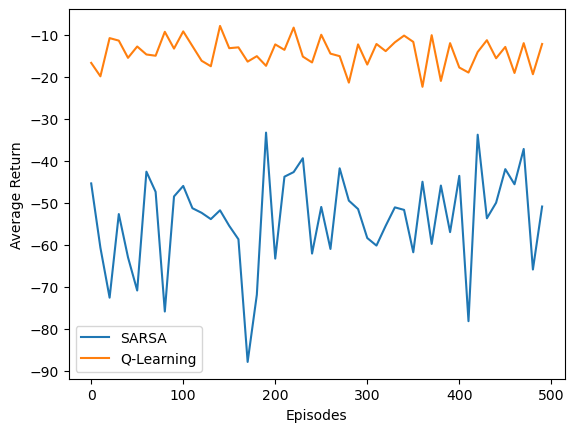

In [37]:
# Experiment settings
num_episodes = 500
alpha = 0.5
gamma = 1.0
epsilon = 0.1
eval_interval = 10

# Create the Windy Gridworld environment
env = WindyGridworldKing()

# Evaluate the SARSA and Q-learning algorithms using the specified hyperparameters
sarsa_returns = evaluate_algorithm(sarsa, env, num_episodes, alpha, gamma, epsilon, eval_interval)
q_learning_returns = evaluate_algorithm(q_learning, env, num_episodes, alpha, gamma, epsilon, eval_interval)

# Plot the learning curves for both algorithms
plt.plot(np.arange(len(sarsa_returns)) * eval_interval, sarsa_returns, label='SARSA')
plt.plot(np.arange(len(q_learning_returns)) * eval_interval, q_learning_returns, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.legend()
plt.show()

The resulting figure shows the learning curves for both algorithms on the same plot. The figure shows that both algorithms start with low average returns and gradually improve over time. However, Q-learning appears to converge to a higher average return than SARSA, suggesting that it may be a more effective algorithm for the Windy Gridworld problem  with King's Moves and Stochastic wind.
